In [58]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from sympy.physics.quantum.constants import hbar
from sympy import pi, symbols, integrate, oo, Sum, simplify, sinh

## 1.2 Boltzmann Modell

Klassische Hamilton-Funktion des Oszillators:
\begin{equation}
H(\boldsymbol{p}, \boldsymbol{x})=\frac{\boldsymbol{p}^2}{2 m}+\frac{K}{2} \boldsymbol{x}^2=E
\end{equation}
$p$ und $x$ sind die dreidimsonionalen Vektoren des Impulses und der Auslenkung bezüglich des Ursprungs.

Kanonische Zustandssumme $Z_K$ mit Temperatur $T$ und der Kältefunktion $\beta=\frac{1}{k_B T}$ ergibt sich zu:
\begin{equation}
Z_k=\int \frac{\boldsymbol{d p}}{(2 \pi \hbar)^3} \int \boldsymbol{d x} e^{-\beta H(p, x)}
\end{equation}

In [59]:
# kb = constants.k
# hbar = constants.hbar

In [60]:
m, K, T, kb, beta, omega = symbols('m K T k_B β ω', real=True, positive=True)
x, p = symbols('x p ', real=True)

H = (p**2)/(2*m)+(K/2)*x**2
factor = (1/(2*pi*hbar)**3)
fx = sp.exp(-(1/(kb*T))*((K/2)*x**2))
fp = sp.exp(-(1/(kb*T))*((p**2)/(2*m)))
fp

exp(-p**2/(2*T*k_B*m))

### a) Berechnung der kanonischen Zustandssumme
Da die $p$ und $x$ unabhängige Variablen sind kann das Integral entkoppelt werden:
\begin{equation}
Z=\int e^{-\beta \frac{y^2}{2 m}} d p \cdot \int e^{-\beta \frac{K}{2} x^2} d x
\end{equation}
Nach der Definition sind die Variablen $p$ und $x$ der Hamilton-Funktion unabhängig.
Da die Masse $m$ von der Federkonstanten $K$ in allen Raumrichtungen gleich zurückgestellt wird, vereinfacht sich durch die Symmetrie des Problems die Integration weiter zu:
\begin{equation}
Z=\left(\int e^{-\beta \frac{p^2}{2 m}} d p_x\right)^3 \cdot\left(\int e^{-\beta \frac{K}{2} x_x^2} d x_x\right)^3
\end{equation}

In [61]:
Zk1 = (integrate(fx, (x, -oo, oo)))**3
Zk2 = (integrate(fp, (p, -oo, oo)))**3
Zk = factor * Zk1 * Zk2
Zk = Zk.subs(T*kb, beta**(-1))
Zk

m**(3/2)/(hbar**3*K**(3/2)*β**3)

Somit ergibt sich zusätzlich mit $\omega=\sqrt{\frac{K}{m}}$ die kanonische Zustandssumme zu:
\begin{equation*}
Z=\frac{1}{(\hbar\omega\beta)^3}
\end{equation*}
Mit ihr lassen sich alle wichtigen thermodynamischen Größen ableiten. Sie bildet die Brücke zwischen der mikroskopischen Beschreibung eines System und der makroskopischen thermodynamischen Beschreibung.

### b) Berechnung der freien Energie
Für die freie Energie gilt:
\begin{equation}
\langle E\rangle=\frac{\sum_n E_n \cdot e^{-\beta E_n}}{\sum_n e^{-\beta E_n}}=-\frac{1}{Z_k} \cdot \frac{\partial Z_k}{\partial \beta}
\end{equation}

In [62]:
E = -(1/Zk)*sp.diff(Zk, beta)
E

3/β

In [63]:
E = E.subs(beta, 1/(kb*T))
E

3*T*k_B

Um die Wärmekapazität mit $N=1$ zu berechnen wird folgender Zusammenhang verwendet:
\begin{equation}
C=\frac{d\langle E\rangle}{dT}\cdot N
\end{equation}

In [64]:
N = symbols('N')
C = sp.diff(E, T)*N
C

3*N*k_B

Somit ergibt sich eine Wärmekapatität von:
\begin{equation}
C=3k_B
\end{equation}

### c)
Die Wärmekapazität für N Oszillatoren lautet $C=3k_BN$

Da sich das Dulong-Petit-Gesetz auf die Relation der molaren Wärmekapazität und der universellen Gaskonstante bezieht, ergibt aus der idealen Gasgleichung und Division durch die Stoffmenge $\nu$:
\begin{equation}
C_{mol}=\frac{C}{\nu}=3\frac{N}{\nu}k_B=3\frac{\nu}{\nu}R=3\cdot R
\end{equation}

## 1.3 Einstein-Modell

### a)
Der eindimensionale quantenmechanische Oszillator besitzt die Energieeigenwerte $E_n=\hbar \omega(n+1 / 2)$ mit ganzzahliger Quantenzahl $n$.
Die Zustandssumme lautet:
\begin{equation}
Z=\sum_n e^{-\beta E_n}
\end{equation}

In [65]:
n = symbols('n')

En = hbar*omega*(n+(1/2))
Z = Sum(sp.exp(-beta*En), (n, 0, oo))
Z

Sum(exp(-hbar*β*ω*(n + 0.5)), (n, 0, oo))

In [66]:
Z = Z.doit()
simplify(Z)

exp(-0.5*hbar*β*ω)*Sum(exp(-hbar*n*β*ω), (n, 0, oo))

In [67]:
r = symbols('r')

Z = Sum(r**n, (n, 0, oo))
Z = Z.doit().simplify().subs(r, sp.exp(-beta*hbar*omega))
Z

Piecewise((-1/(-1 + exp(-hbar*β*ω)), exp(-hbar*β*ω) < 1), (Sum(exp(-hbar*n*β*ω), (n, 0, oo)), True))

In [68]:
Z = (-1/(-1 + sp.exp(-hbar*beta*omega))) * sp.exp(-0.5*beta*hbar*omega)
Z

-exp(-0.5*hbar*β*ω)/(-1 + exp(-hbar*β*ω))

Mit den folgenden Umformungen erhält man für Z schließlich:
\begin{equation}
Z=\frac{e^{-\frac{\hbar \omega \beta}{2}}}{1-e^{-\hbar \omega \beta}}=\frac{e^{-\frac{\hbar \omega \beta}{2}}}{e^{-\frac{\hbar \omega \beta}{2}}\left(e^{\frac{\hbar \omega \beta}{2}}-e^{-\frac{\hbar \omega \beta}{2}}\right)}=\frac{1}{\left(e^{\frac{\hbar \omega \beta}{2}}-e^{-\frac{\hbar \omega \beta}{2}}\right)}=\frac{1}{2 \cdot\left(\frac{e^{\frac{\hbar \omega}{2}}-e^{-\frac{\hbar \omega \beta}{2}}}{2}\right)}=\frac{1}{2 \sinh \left(\frac{\hbar \omega \beta}{2}\right)}
\end{equation}
Die Eigenenergieen sind diejenigen Energieen, die der Oszillator annhemen kann.

In [69]:
Z = 1/(2*sinh(hbar*beta*omega/2))
Z

1/(2*sinh(hbar*β*ω/2))

### b)
Die Berechnungen der Energie und der Wärmekapazität eines einzelnen harmonischen Oszillators erfolgen analog zu der Berechnung aus Aufgabe 1.2

In [70]:
E = -(1/Z)*sp.diff(Z, beta)
E.simplify()

hbar*ω/(2*tanh(hbar*β*ω/2))

In [71]:
E = E.subs(beta, 1/(kb*T))#.simplify()
E

hbar*ω*cosh(hbar*ω/(2*T*k_B))/(2*sinh(hbar*ω/(2*T*k_B)))

Unter Verwendung der Identität $\operatorname{coth} x=1+\frac{2}{e^{2 x}-1}$ ergibt sich für die mittlere freie Energie des quantenmechanischen harmonischen Oszillators
\begin{equation}
\langle E\rangle=\frac{\hbar \omega}{2 \tanh \left(\frac{\hbar \omega \beta}{2}\right)}=\frac{\hbar \omega}{2} \operatorname{coth}\left(\frac{\hbar \omega \beta}{2}\right)=\frac{\hbar \omega}{2}\left(1+\frac{2}{e^{\hbar \omega \beta}-1}\right)=\operatorname{\hbar\omega }\left(\frac{1}{e^{\hbar \omega \beta}-1}+\frac{1}{2}\right)
\end{equation}

In [72]:
C = sp.diff(E, T)
# C.subs(T*kb, beta**(-1)).simplify()
C.simplify()

hbar**2*ω**2/(2*T**2*k_B*(cosh(hbar*ω/(T*k_B)) - 1))

Unter Verwendung des Additionstheorems für den Cosinus Hyperbolicus $\cosh 2 x-1=2 \sinh ^2 x$ ergibt sich die Wärmekapazität zu
\begin{equation*}
\frac{\hbar^2 \omega^2}{2 k_B T^2} \frac{1}{\cosh\left(\frac{\hbar \omega}{k_B T}\right)-1}=\frac{\hbar^2 \omega^2}{2 k_B T^2} \frac{1}{\cosh \left(2\cdot \frac{\hbar \omega}{2 k_B T}\right)-1}=\frac{\hbar^2 \omega^2}{2 k_B T^2} \frac{1}{2 \sinh ^2\left(\frac{\hbar \omega}{2 k_B T}\right)}=\frac{1}{k_B}\left(\frac{\hbar \omega}{2 T \sinh \left(\frac{\hbar \omega}{2 k_B T}\right)}\right)^2
\end{equation*}
\begin{equation}
C=k_B\left(\frac{\frac{\hbar \omega}{2 k_B T}}{\sinh \left(\frac{\hbar \omega}{2 k_B T}\right)}\right)^2
\end{equation}

### c)
Würde man einen dreidimensionalen Oszillator betrachten, würde nach dem Virialsatz $E_{kin}=E_{pot}$ gelten und somit auf drei Freiheitsgrade das dreifache der Energie fallen. Gleiches ergibt sich für die Wärmekapazität.

### d)

In [73]:
def Ckb1(x):
    return ((0.5*x)/(np.sinh(0.5*x)))**2

In [74]:
def Ckb2(x):
    return ((0.5*1/x)/(np.sinh(0.5*1/x)))**2

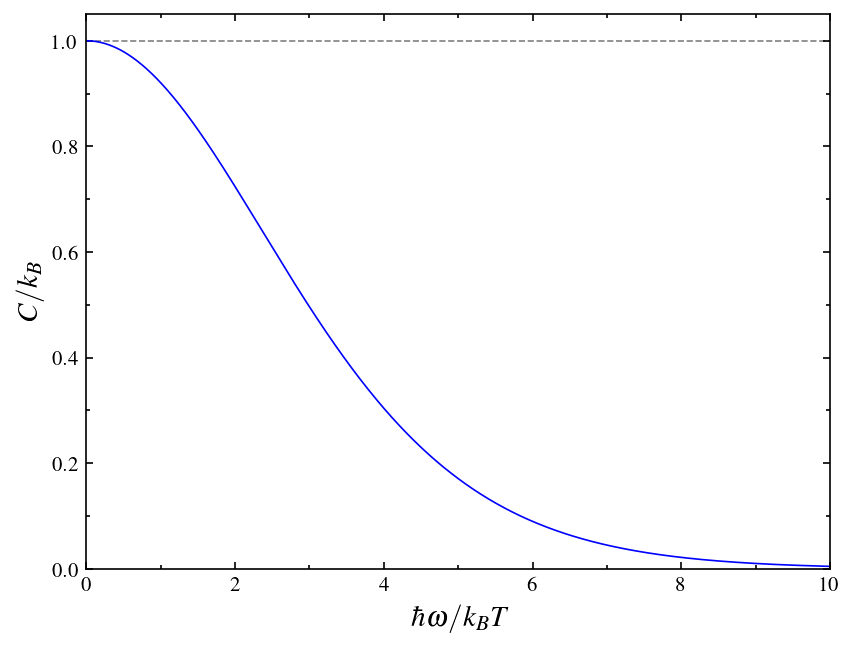

In [75]:
fig, ax = plt.subplots(dpi=150)

plt.rcParams["font.family"] = "times"
plt.rcParams["text.usetex"] = True

x = np.linspace(.001, 10, 1000)

ax.plot(x, Ckb1(x),
        c='blue',
        linewidth=.8,
        zorder=2)
ax.axhline(1,
           color='grey',
           linestyle='--',
           linewidth=0.8,
           zorder=1)

ax.set_ylabel('$C/k_B$', fontsize=14)
ax.set_xlabel(r'$\hbar \omega/k_B T$', fontsize=14)

ax.set_xlim(0, 10)
ax.set_ylim(0, 1.05)

ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
plt.tick_params(which='minor',direction='in', labelsize=10, width=.8, length=2, bottom=True, top=True, left=True, right=True)
plt.tick_params(which='major',direction='in', labelsize=10, width=.8, bottom=True, top=True, left=True, right=True)

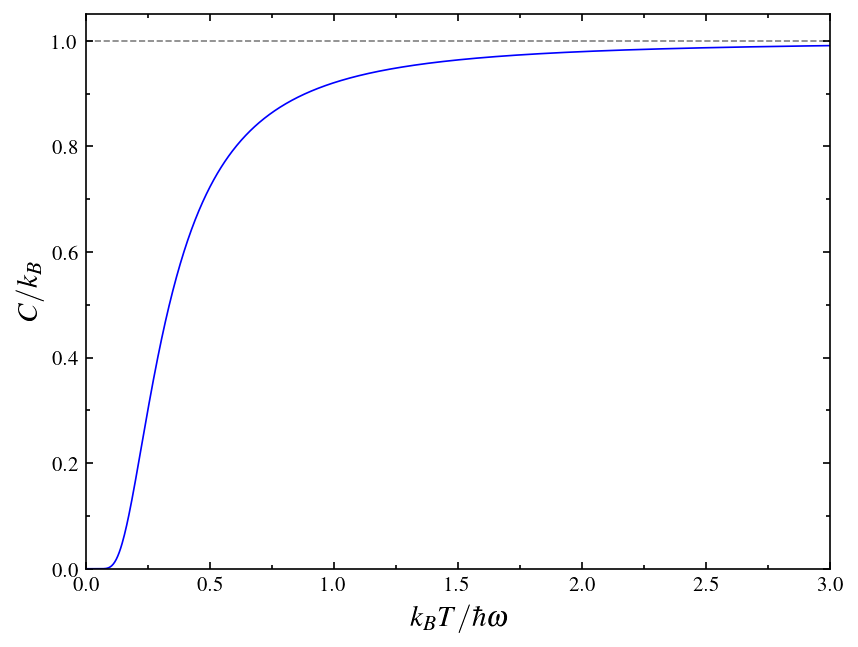

In [76]:
fig, ax = plt.subplots(dpi=150)

plt.rcParams["font.family"] = "times"
plt.rcParams["text.usetex"] = True

x = np.linspace(.001, 3, 1000)

ax.plot(x, Ckb2(x),
        c='blue',
        linewidth=.8,
        zorder=2)
ax.axhline(1,
           color='grey',
           linestyle='--',
           linewidth=0.8,
           zorder=1)

ax.set_ylabel('$C/k_B$', fontsize=14)
ax.set_xlabel(r'$k_B T/\hbar \omega$', fontsize=14)

ax.set_xlim(0, 3)
ax.set_ylim(0, 1.05)

ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
plt.tick_params(which='minor',direction='in', labelsize=10, width=.8, length=2, bottom=True, top=True, left=True, right=True)
plt.tick_params(which='major',direction='in', labelsize=10, width=.8, bottom=True, top=True, left=True, right=True)

Das Reziproke Argument ermöglicht es, eine bessere visuelle Aussage über das Verhalten der Wärmekapazität bei sehr hohen Temperaturen zu treffen.
Ees ergeben sich folgende Grenzfälle:
\begin{equation}
C \cong\left\{\begin{array}{cc}
k_B\left(\frac{\hbar \omega}{k_B T}\right)^2 \exp \left(-\frac{\hbar \omega}{k_B T}\right), & k_B T \ll \hbar \omega \\
k_B, & k_B T \gg \hbar \omega
\end{array}\right.
\end{equation}

Für hohe Temperaturen entspricht die Wärmekapazität also wieder ungefähr dem Dulong-Petit-Gesetz $C\cong k_B$